In [34]:
from __future__ import annotations
import numpy as np
from pathlib import Path
from typing import List, Tuple, Dict, Set
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


In [35]:
CLASSES = ["backward", "forward", "left", "on", "right", "stop", "off"]
TARGET_LEN = 16000

LABEL_TABLE = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(CLASSES),
        values=tf.constant(list(range(len(CLASSES))), dtype=tf.int32),
    ),
    default_value=-1,
)

def read_txt_list(path: Path) -> Set[str]:
    return {
        line.strip().replace("\\", "/")
        for line in path.read_text().splitlines()
        if line.strip()
    }

def get_all_audio_files(data_root: Path) -> List[str]:
    files = []
    for cls in CLASSES:
        files.extend(str(p) for p in (data_root / cls).glob("*.wav"))
    return files

def split_by_lists(
    data_root: Path,
    all_files: List[str],
    val_list: Set[str],
    test_list: Set[str],
) -> Tuple[List[str], List[str], List[str]]:
    train, val, test = [], [], []
    for f in all_files:
        rel = Path(f).relative_to(data_root).as_posix()
        if rel in val_list:
            val.append(f)
        elif rel in test_list:
            test.append(f)
        else:
            train.append(f)
    return train, val, test

def load_audio(file_path: tf.Tensor) -> tf.Tensor:
    audio = tf.io.read_file(file_path)
    waveform, _ = tf.audio.decode_wav(audio, desired_channels=1)
    waveform = tf.squeeze(waveform, axis=-1)

    length = tf.shape(waveform)[0]
    waveform = tf.cond(
        length < TARGET_LEN,
        lambda: tf.pad(waveform, [[0, TARGET_LEN - length]]),
        lambda: waveform[:TARGET_LEN],
    )
    waveform.set_shape([TARGET_LEN])
    return waveform

def get_label(file_path: tf.Tensor) -> tf.Tensor:
    path = tf.strings.regex_replace(file_path, r"\\", "/")
    parts = tf.strings.split(path, "/")
    label_name = parts[-2]  # имя папки
    return LABEL_TABLE.lookup(label_name)

def make_dataset(files: List[str], batch_size=32, shuffle=False) -> tf.data.Dataset:
    ds = tf.data.Dataset.from_tensor_slices(files)
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(files), 5000), reshuffle_each_iteration=True)

    ds = ds.map(lambda fp: (load_audio(fp), get_label(fp)),
                num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

def load_datasets(data_root: str, batch_size=32):
    data_root = Path(data_root)

    val_list = read_txt_list(data_root / "validation_list.txt")
    test_list = read_txt_list(data_root / "testing_list.txt")

    all_files = get_all_audio_files(data_root)
    train_files, val_files, test_files = split_by_lists(data_root, all_files, val_list, test_list)

    print(f"Train: {len(train_files)} | Val: {len(val_files)} | Test: {len(test_files)}")

    return {
        "train": make_dataset(train_files, batch_size, shuffle=True),
        "val": make_dataset(val_files, batch_size, shuffle=False),
        "test": make_dataset(test_files, batch_size, shuffle=False),
    }

datasets = load_datasets("/content/data", batch_size=64)
x, y = next(iter(datasets["train"]))
print(x.shape, y[:10].numpy())

Train: 17825 | Val: 2100 | Test: 2337
(64, 16000) [1 2 2 2 0 2 1 2 2 0]


In [40]:
def extract_features(x, y):
    """
    x: [B, 16000]
    y: labels
    """

    mfcc = waveform_to_mfcc(x)

    delta = tf.signal.frame(mfcc[:, 1:] - mfcc[:, :-1], frame_length=1, frame_step=1)
    delta = tf.squeeze(delta, axis=2)

    delta2 = tf.signal.frame(delta[:, 1:] - delta[:, :-1], frame_length=1, frame_step=1)
    delta2 = tf.squeeze(delta2, axis=2)

    def stats(feat):
        return tf.concat([
            tf.reduce_mean(feat, axis=1),
            tf.math.reduce_std(feat, axis=1),
            tf.reduce_min(feat, axis=1),
            tf.reduce_max(feat, axis=1),
            tfp.stats.percentile(feat, 25.0, axis=1),
            tfp.stats.percentile(feat, 75.0, axis=1),
        ], axis=1)

    features = tf.concat([
        stats(mfcc),
        stats(delta),
        stats(delta2)
    ], axis=1)

    return features, y

In [41]:
SR = 16000
FRAME_LEN = 400
FRAME_STEP = 160
FFT_LEN = 512

NUM_MEL_BINS = 40
NUM_MFCC = 13

import tensorflow as tf

import tensorflow_probability as tfp

def time_diff(feat):
    """
    feat: [B, T, C]
    returns: [B, T, C] (с сохранением длины через pad)
    """
    d = feat[:, 1:, :] - feat[:, :-1, :]
    d = tf.pad(d, paddings=[[0,0],[0,1],[0,0]])
    return d

def stats(feat):
    """
    feat: [B, T, C]
    returns: [B, C*6]
    """
    mean = tf.reduce_mean(feat, axis=1)
    std  = tf.math.reduce_std(feat, axis=1)
    mn   = tf.reduce_min(feat, axis=1)
    mx   = tf.reduce_max(feat, axis=1)
    p25  = tfp.stats.percentile(feat, 25.0, axis=1, interpolation='linear')
    p75  = tfp.stats.percentile(feat, 75.0, axis=1, interpolation='linear')
    return tf.concat([mean, std, mn, mx, p25, p75], axis=1)

def extract_features(x, y):
    mfcc = waveform_to_mfcc(x)

    d1 = time_diff(mfcc)
    d2 = time_diff(d1)
    energy = tf.reduce_mean(tf.square(x), axis=1, keepdims=True)

    feats = tf.concat([stats(mfcc), stats(d1), stats(d2), energy], axis=1)
    return feats, y

In [38]:
def mfcc_stats(mfcc: tf.Tensor) -> tf.Tensor:
    """
    mfcc: [frames, NUM_MFCC]
    return: features [2*NUM_MFCC]
    """
    mean = tf.reduce_mean(mfcc, axis=0)
    var  = tf.math.reduce_variance(mfcc, axis=0)

    feats = tf.concat([mean, var], axis=0)
    return feats

In [42]:
train_feat = datasets["train"].map(
    extract_features,
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

val_feat = datasets["val"].map(
    extract_features,
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

test_feat = datasets["test"].map(
    extract_features,
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)



def dataset_to_numpy(ds):
    X, y = [], []
    for xb, yb in ds:
        X.append(xb.numpy())
        y.append(yb.numpy())
    return np.concatenate(X), np.concatenate(y)


X_train, y_train = dataset_to_numpy(train_feat)
X_val, y_val = dataset_to_numpy(val_feat)
X_test, y_test = dataset_to_numpy(test_feat)

print(X_train.shape, y_train.shape)

(17825, 235) (17825,)


In [55]:

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
        max_iter=2000,
        multi_class="multinomial",
        solver="lbfgs",
        n_jobs=-1
    ))
])

clf.fit(X_train, y_train)

val_pred = clf.predict(X_val)
print("Val accuracy:", accuracy_score(y_val, val_pred))

test_pred = clf.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, test_pred))

print(classification_report(y_test, test_pred, target_names=CLASSES))
cm1 = confusion_matrix(y_test, test_pred)
print(cm1)



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Val accuracy: 0.8142857142857143
Test accuracy: 0.842533162173727
              precision    recall  f1-score   support

    backward       0.78      0.79      0.79       165
     forward       0.86      0.86      0.86       155
        left       0.78      0.83      0.80       412
          on       0.89      0.85      0.87       396
       right       0.83      0.84      0.84       396
        stop       0.89      0.89      0.89       411
         off       0.84      0.82      0.83       402

    accuracy                           0.84      2337
   macro avg       0.84      0.84      0.84      2337
weighted avg       0.84      0.84      0.84      2337

[[131   3   8   6   8   3   6]
 [  5 133   3   4   3   2   5]
 [ 11   3 340   4  33  12   9]
 [  7   2   9 338   5  10  25]
 [ 10   5  36   5 333   2   5]
 [  2   0  23   1   6 365  14]
 [  1   8  16  23  11  14 329]]


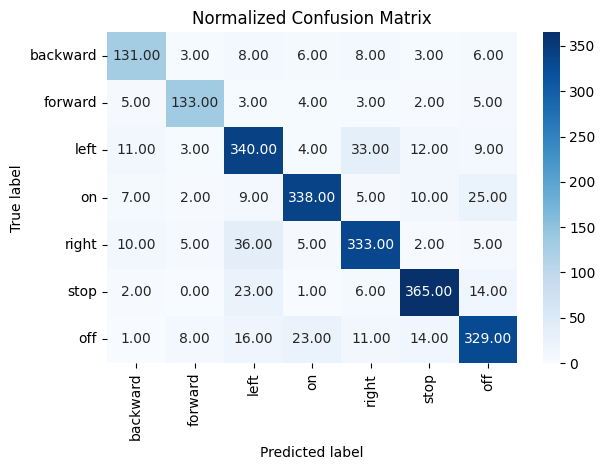

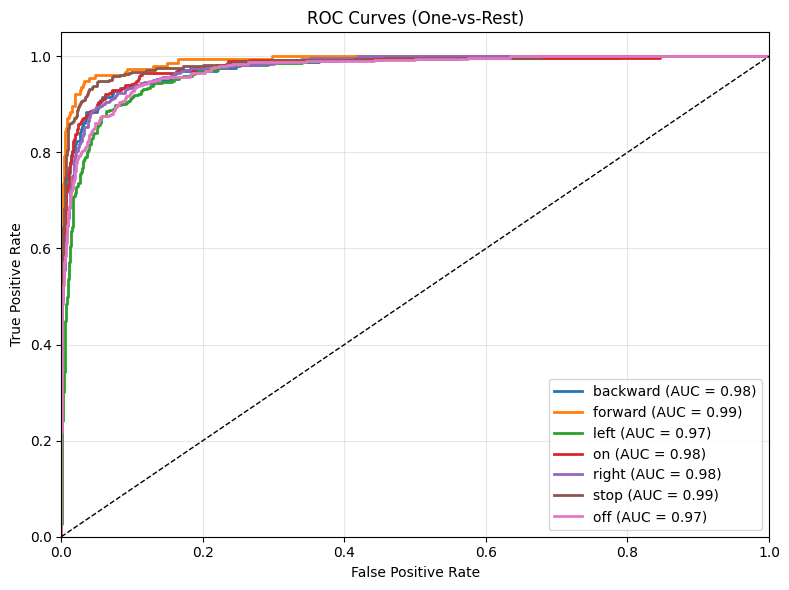

In [56]:
sns.heatmap(
    cm1,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=CLASSES,
    yticklabels=CLASSES
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()

import numpy as np


y_proba = clf.predict_proba(X_test)

y_test_bin = label_binarize(y_test, classes=range(len(CLASSES)))

plt.figure(figsize=(8, 6))

for i, class_name in enumerate(CLASSES):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(
        fpr,
        tpr,
        lw=2,
        label=f"{class_name} (AUC = {roc_auc:.2f})"
    )

plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [71]:

x_batch, y_batch = next(iter(datasets["test"]))
B = int(x_batch.shape[0])

k = 5
idx = np.random.choice(B, size=min(k, B), replace=False)
x5 = tf.gather(x_batch, idx)

t0 = time.perf_counter()

dummy_y = tf.zeros([tf.shape(x5)[0]], dtype=tf.int32)
feat5, _ = extract_features(x5, dummy_y)
feat5_np = feat5.numpy()

pred_ids = clf.predict(feat5_np)
t1 = time.perf_counter()

total_ms = (t1 - t0) * 1000
per_sample_ms = total_ms / feat5_np.shape[0]

print(f"Picked indices: {idx}")
print(f"Features shape: {feat5_np.shape}")
print(f"Total time (preprocess + predict): {total_ms:.2f} ms")
print(f"Per-sample time: {per_sample_ms:.2f} ms")

pred_names = [CLASSES[int(i)] for i in pred_ids]
print("Predicted:", pred_names)


Picked indices: [61 40  7 46  4]
Features shape: (5, 235)
Total time (preprocess + predict): 97.73 ms
Per-sample time: 19.55 ms
Predicted: ['backward', 'backward', 'backward', 'backward', 'backward']


In [48]:


clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(
        kernel="rbf",
        C=10,
        gamma="scale",
        probability=True,
        random_state=42
    ))
])

clf.fit(X_train, y_train)

val_pred = clf.predict(X_val)
test_pred = clf.predict(X_test)

print("Val accuracy:", accuracy_score(y_val, val_pred))
print("Test accuracy:", accuracy_score(y_test, test_pred))

print(classification_report(y_test, test_pred, target_names=CLASSES))

cm = confusion_matrix(y_test, test_pred)
print(cm)


Val accuracy: 0.8161904761904762
Test accuracy: 0.8275566966195977
              precision    recall  f1-score   support

    backward       0.81      0.75      0.78       165
     forward       0.90      0.86      0.88       155
        left       0.75      0.87      0.81       412
          on       0.84      0.83      0.83       396
       right       0.80      0.83      0.82       396
        stop       0.88      0.84      0.86       411
         off       0.86      0.79      0.83       402

    accuracy                           0.83      2337
   macro avg       0.84      0.82      0.83      2337
weighted avg       0.83      0.83      0.83      2337

[[123   3  12   8  16   2   1]
 [  5 133   5   3   3   2   4]
 [  9   0 359   1  30  11   2]
 [  6   4  11 327  11  12  25]
 [  2   3  43   7 329  10   2]
 [  5   2  28   3  12 345  16]
 [  2   3  18  39  10  12 318]]


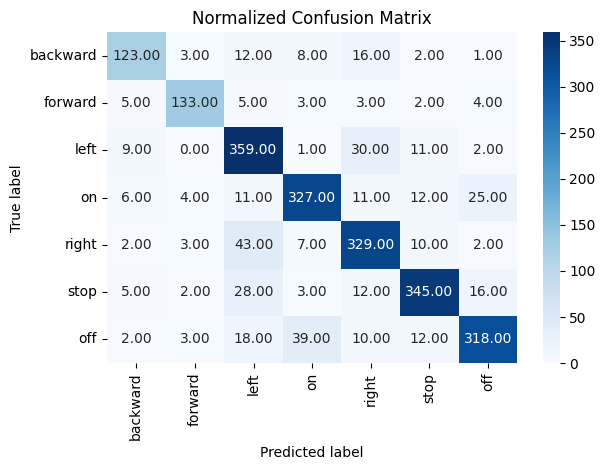

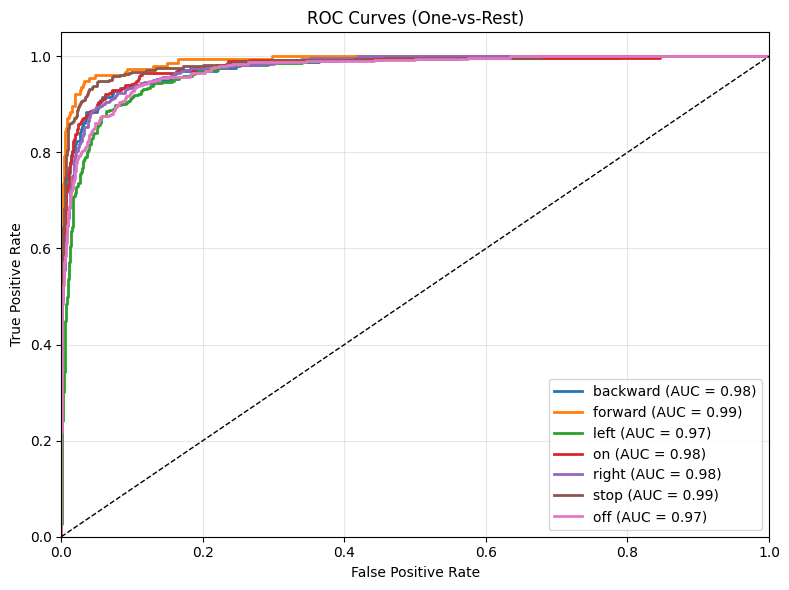

In [57]:
sns.heatmap(
    cm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=CLASSES,
    yticklabels=CLASSES
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_proba = clf.predict_proba(X_test)

y_test_bin = label_binarize(y_test, classes=range(len(CLASSES)))

plt.figure(figsize=(8, 6))

for i, class_name in enumerate(CLASSES):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(
        fpr,
        tpr,
        lw=2,
        label=f"{class_name} (AUC = {roc_auc:.2f})"
    )

plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [72]:


x_batch, y_batch = next(iter(datasets["test"]))
B = int(x_batch.shape[0])

k = 5
idx = np.random.choice(B, size=min(k, B), replace=False)
x5 = tf.gather(x_batch, idx)

t0 = time.perf_counter()

dummy_y = tf.zeros([tf.shape(x5)[0]], dtype=tf.int32)
feat5, _ = extract_features(x5, dummy_y)
feat5_np = feat5.numpy()

pred_ids = clf.predict(feat5_np)

t1 = time.perf_counter()

total_ms = (t1 - t0) * 1000
per_sample_ms = total_ms / feat5_np.shape[0]

print(f"Total time (preprocess + predict): {total_ms:.2f} ms")
print(f"Per-sample time: {per_sample_ms:.2f} ms")

Total time (preprocess + predict): 98.57 ms
Per-sample time: 19.71 ms
